---
title: Classification
format:
  html:
      embed-resources: true
      code-fold: true
      cite-method: biblatex
---

## Introduction to Classification Decision Trees

*Note: Decision Tree introduction is on Regression tab.*

For classification Decision Trees, the target variable takes a discrete set of values. Unlike regression trees where the aim is to predict a generalized value for the target variable, classification trees attempt to assign class labels to records based on a given set of labels in training data. Thus, each leaf is a particular class label, serving as a prediction for all records that follow its respective sequence of conditions.

## Classification Trees for Record Data

### Class Distribution

The record data we will be using comes from the IPUMS dataset containing results from the US Census Bureau. Our target variable will be `commute_method`, which each respondants answer to what their primary mode of transportation is for work. As this data has been cleaned, this categorical variable is portrayed via text with the following classes, with their respective totals:

- Private Vehicle - 47254 answers
- Public Transit - 3365
- Bicycle - 593
- Walked - 2322
- Worked from Home - 19013
- Other - 1156

The following is a visualization of the class distribution:

![Distribution of Commute Methods](../../images/bar1.png)

### Over/under-sampling

As we can see the bar graph, `Private Vehicle` and `Worked from Home` make up a significant majority of the data in this set. This creates problems for classification, as the algorithm will tend to predict only those classes to maximize accuracy. Thus, it is common practice to under-sample from those classes to gain better insights.

While this will produce a tree that better represents predictions for each class, it is important to note that this is not the distribution of the original data. For this purpose, we will remove a random sample of 44,000 `Private Vehicle` responses and 17,000 `Worked from Home` responses. The code for that is below, with the new class distribution:

In [ ]:
ipums <- read.csv("../../data/cleaned_data/ipums_cleaned.csv")
ipums2 <- ipums[-sample(which(ipums$commute_method=="Private Vehicle"), 44000),]
ipums2 <- ipums2[-sample(which(ipums2$commute_method=="Worked From Home"), 17000),]
table(ipums2$commute_method)

![Distribution of Commute Methods](../../images/bar3.png)

### Applying the Model

After re-sizing the data, we can now split the records into training and testing sets and generate a decision tree. The code and outputs are below:

In [ ]:
train_size2 <- floor(nrow(ipums2)*(.8))
test_size2 <- nrow(ipums2) - train_size2
set.seed(1000)
train2 <- ipums2[sample(nrow(ipums2), train_size2,replace=FALSE),]
test2 <- ipums2[-sample(nrow(ipums2), train_size2,replace=FALSE),]
ipums_tree2 <- rpart(commute_method ~ city_population_00s + age + income, data = train2, method="class")
fancyRpartPlot(ipums_tree2,main = "Commute Method Decision Tree")

![Commute Methods Decision Tree](../../images/class1.png)

The main things to note from this tree are the variables included in each condition. Firstly, we can notice that respondants with lower incomes are more likely to be placed in the `Public Transit` class than those with high incomes. Additionally, those in cities with greater populations are more likely to take `Public Transit` according to this data.

### Results

The results of this classification tree are below:

In [ ]:
library(cvms)
prediction2 = predict(ipums_tree2, test2[,-which(names(test) %in% c("commute_method"))], type="class")
conf_mat <- confusion_matrix(targets = test2$commute_method,
                             predictions = prediction2)
plot_confusion_matrix(conf_mat$`Confusion Matrix`[[1]], rotate_y_text = FALSE)

![Confusion Matrix](../../images/class_confusion.png)

While it is notable that no predictions went to the `Walked`, `Bicycle`, and `Worked From Home` classes, we can still gather information from the accuracy given by this confusion matrix. Ultimately, values on the diagonals are the largest values for each of the three populated rows, indicating relative accuracy from the model.

## Classification Trees for Text Data

100%|██████████| 2434/2434 [00:32<00:00, 74.99it/s] 


Text(0.5, 1.0, 'Yelp Word Cloud')

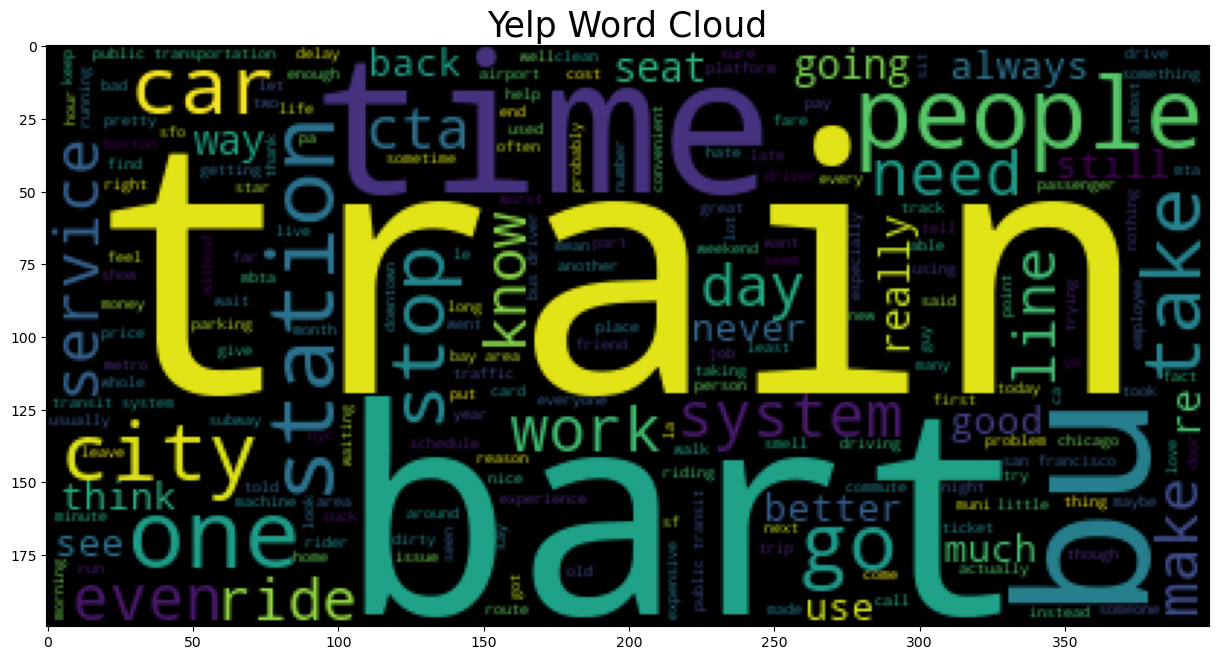

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.metrics import accuracy_score
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from tqdm import tqdm
import string
from collections import Counter
tqdm.pandas()
token_counter = Counter()
yelp=pd.read_csv('../../data/cleaned_data/total_yelp.csv')  
lemmatizer = WordNetLemmatizer()
custom_stoplemmas = [
    'be',
    'ir',
    'll',
    'nt',
    'quot',
    'rd',
    's',
    've'
]

def remove_special_chars(token):
  return token.translate(str.maketrans('', '', string.punctuation))

def remove_digits(token):
  return ''.join([c for c in token if not c.isdigit()])

def clean_review(review_text):
  review_cleaned = review_text.lower()
  review_sents = sent_tokenize(review_cleaned)
  clean_sents = []
  for cur_sent in review_sents:
    sent_tokens = word_tokenize(cur_sent)
    sent_tokens_cleaned = [t for t in sent_tokens if t not in stopwords.words('english')]
    sent_tokens_cleaned = [remove_digits(t) for t in sent_tokens_cleaned]
    sent_tokens_cleaned = [t.replace("-", " ") for t in sent_tokens_cleaned]
    sent_tokens_cleaned = [remove_special_chars(t) for t in sent_tokens_cleaned]
    sent_tokens_cleaned = [t for t in sent_tokens_cleaned if len(t) > 0]
    sent_tokens_cleaned = [lemmatizer.lemmatize(t) for t in sent_tokens_cleaned]
    sent_tokens_cleaned = [t for t in sent_tokens_cleaned if t not in custom_stoplemmas]
    token_counter.update(sent_tokens_cleaned)
    clean_sent = ' '.join(sent_tokens_cleaned)
    clean_sents.append(clean_sent)
  review_final = ". ".join(clean_sents)
  return review_final
yelp['Review_clean'] = yelp['Review'].progress_apply(clean_review)
import wordcloud
import matplotlib.pyplot as plt
wordcloud = wordcloud.WordCloud(min_word_length = 2,max_words = 200).generate(yelp['Review_clean'].str.cat())
fig = plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.title('Yelp Word Cloud',fontsize = 25)


### Class Distribution

<Axes: xlabel='Rating'>

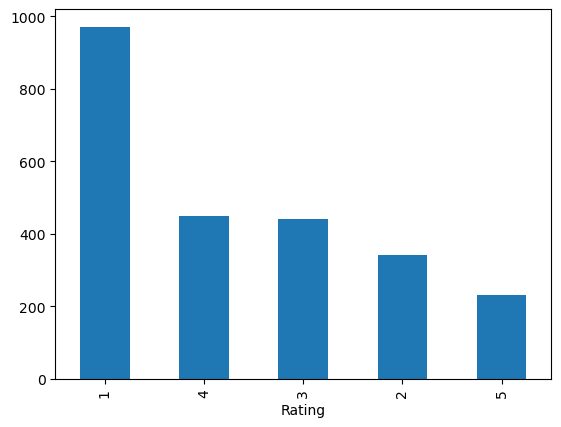

In [60]:
yelp['Rating'].value_counts().plot(kind='bar')

In [ ]:
corpus=yelp["Review"].to_list()
y=yelp["Rating"].to_numpy()
vectorizer=CountVectorizer(min_df=0.001)   

Xs  =  vectorizer.fit_transform(corpus)   
X=np.array(Xs.todense())

maxs=np.max(X,axis=0)
X=np.ceil(X/maxs)

from sklearn.model_selection import train_test_split
test_ratio=0.2

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=0)
y_train=y_train.flatten()
y_test=y_test.flatten()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier


# HYPER PARAMETER SEARCH FOR OPTIMAL NUMBER OF NEIGHBORS 
num_neighbors=[]
train_accuracy=[]
test_accuracy=[]

# LOOP OVER HYPER-PARAM
for i in range(1,40):
    # INITIALIZE MODEL 
    model = KNeighborsClassifier(n_neighbors=i)

    # TRAIN MODEL 
    model.fit(x_train,y_train)

    # LABEL PREDICTIONS FOR TRAINING AND TEST SET 
    yp_train = model.predict(x_train)
    yp_test = model.predict(x_test)

    print("n_neighbors =",i)
    acc1=accuracy_score(y_train, yp_train)*100
    acc2=accuracy_score(y_test, yp_test)*100

    num_neighbors.append(i)
    train_accuracy.append(acc1)
    test_accuracy.append(acc2)

    print(" train accuracy:",acc1)
    print(" test accuracy:" ,acc2)

n_neighbors = 1
 train accuracy: 99.94863893168979
 test accuracy: 38.19301848049281
n_neighbors = 2
 train accuracy: 67.53980482794042
 test accuracy: 39.83572895277207
n_neighbors = 3
 train accuracy: 61.94144838212635
 test accuracy: 41.68377823408625
n_neighbors = 4
 train accuracy: 57.781201848998464
 test accuracy: 43.94250513347023
n_neighbors = 5
 train accuracy: 54.90498202362609
 test accuracy: 44.558521560574945
n_neighbors = 6
 train accuracy: 52.38828967642527
 test accuracy: 44.14784394250513
n_neighbors = 7
 train accuracy: 50.64201335387776
 test accuracy: 43.53182751540041
n_neighbors = 8
 train accuracy: 49.87159732922445
 test accuracy: 44.14784394250513
n_neighbors = 9
 train accuracy: 49.56343091936312
 test accuracy: 43.3264887063655
n_neighbors = 10
 train accuracy: 48.536209553158706
 test accuracy: 42.299794661190965
n_neighbors = 11
 train accuracy: 47.71443246019517
 test accuracy: 43.3264887063655
n_neighbors = 12
 train accuracy: 46.5331278890601
 test accu

Text(0, 0.5, 'Training (black) and test (blue) accuracy')

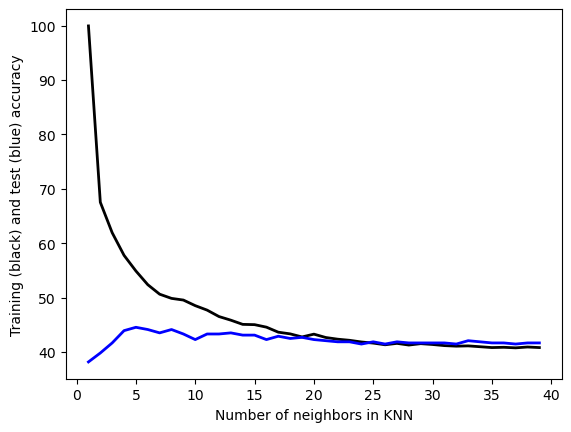

In [ ]:
plt.plot(num_neighbors,train_accuracy ,linewidth=2, color='k')
plt.plot(num_neighbors,test_accuracy ,linewidth=2, color='b')

plt.xlabel("Number of neighbors in KNN")
plt.ylabel("Training (black) and test (blue) accuracy")

In [ ]:
def print_model_summary():
      # LABEL PREDICTIONS FOR TRAINING AND TEST SET 
      yp_train = model.predict(x_train)
      yp_test = model.predict(x_test)

      print("ACCURACY CALCULATION\n")

      print("TRAINING SET:")
      report(y_train,yp_train)

      print("\nTEST SET (UNTRAINED DATA):")
      report(y_test,yp_test)

      print("\nCHECK FIRST 20 PREDICTIONS")
      print("TRAINING SET:")
      print(y_train[0:20])
      print(yp_train[0:20])
      print("ERRORS:",yp_train[0:20]-y_train[0:20])

      print("\nTEST SET (UNTRAINED DATA):")
      print(y_test[0:20])
      print(yp_test[0:20])
      print("ERRORS:",yp_test[0:20]-y_test[0:20])

model = KNeighborsClassifier(n_neighbors=19)

# TRAIN MODEL 
model.fit(x_train,y_train)

# PRINT REPORT USING UTILITY FUNCTION ABOVE
print_model_summary()

ACCURACY CALCULATION

TRAINING SET:
Accuracy: 42.78376990241397
Number of mislabeled points out of a total 1947 points = 1114

TEST SET (UNTRAINED DATA):
Accuracy: 42.71047227926078
Number of mislabeled points out of a total 487 points = 279

CHECK FIRST 20 PREDICTIONS
TRAINING SET:
[1 4 1 1 4 1 3 5 3 2 3 2 2 2 1 1 2 1 2 1]
[1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1]
ERRORS: [ 0 -3  0  0 -3  0 -2 -4 -2  1 -2 -1 -1 -1  0  0 -1  0 -1  0]

TEST SET (UNTRAINED DATA):
[3 4 3 1 3 1 2 4 3 4 4 1 1 1 1 3 2 1 2 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
ERRORS: [-2 -3 -2  0 -2  0 -1 -3 -2 -3 -3  0  0  0  0 -2 -1  0 -1  0]


## Conclusions

To go back to our research questions, this information can give us insight into who is affected by the performance and ubiquity of public transit systems. As our record data shows, public transit is disproportionally used as a means of commuting to work by people in larger cities with lower incomes. Thus, there is societal value in upholding these institutions, as they offer services to those who often depend on them. 